In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt 
import matplotlib.dates 
import datetime
import time
import sklearn
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.grid_search import ParameterGrid
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn import cross_validation
import xgboost as xgb
import rms_data
import rms_eval
import importlib
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
%matplotlib inline
import csv
import sys
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The xgboost version is {}.'.format(xgb.__version__))

The scikit-learn version is 0.17.1.
The xgboost version is 0.6.


In [2]:
#For python 2
reload(rms_eval) #rmspe
reload(rms_data) #performs one-hot-encoding

<module 'rms_data' from 'rms_data.pyc'>

In [3]:
def load_data():
    
    #Read in files
    print "Reading in all three files"
    train = pd.read_csv('train.csv', low_memory=False)
    store = pd.read_csv('store.csv', low_memory=False)
    test = pd.read_csv('test.csv', low_memory=False)
    
    #Select only stores that are open and ?have sales more than 0
    opened = train.Open==1
    salesGT0 = train.Sales > 0
    train = train[opened & salesGT0]
    
    #Join train and store data
    train_store = pd.merge(train, store, on="Store")
    test_store = pd.merge(test, store, on="Store")
    
    #One hot encoding
    train_proc = rms_data.data_prep_v1(train_store)
    test_proc = rms_data.data_prep_v1(test_store, False)
    
    #Store sales in another variable and drop it
    tmp_y = train_proc.Sales
    train_proc.drop('Sales', axis=1, inplace=True)
    train_x = train_proc
    train_y = tmp_y

    #Fill in missing values with -1
    train_x.fillna(-1, inplace=True) #because random forests cannot handle np.nan
    test.fillna(-1, inplace=True)
    
    return train_x, train_y, test_proc

In [4]:
def score(params):
    print "Training with params : "
    print params

    #Create custom scoring function
    skl_rmspe_sqrt = make_scorer(rms_eval.rmspe_sqrt_skl, greater_is_better=True)

    #Create lasso model
    las = linear_model.Lasso(random_state=23497832)
    
    param_grid={'alpha': [params['alpha']]
    }
    
    clf = GridSearchCV(las, param_grid, scoring=skl_rmspe_sqrt, n_jobs=1, cv=5, verbose=5)

    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
        writer.writerow([mean_score] + [scores.std() * 2] + list(params.values()))
        o_f.flush()
    
    return {'loss': mean_score, 'status': STATUS_OK}


In [5]:
def optimize(trials):
    space = {
             #'max_depth': hp.choice('alpha', np.arange(10, 100, dtype=int))
             'alpha' : hp.quniform('alpha', 0.0001, 0.001, 0.0001)
             }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=5)

    print "best parameters ", best

In [6]:
train_x, train_y, test_x = load_data()

X_train, X_test, y_train, y_test = train_test_split(
    train_x.values, train_y.values, test_size=0.15, random_state=1234)

output_file = 'las_hyperopt_log.csv'
headers = [ 'rmspe_mean', 'rmspe_std', 'alpha']
o_f = open( output_file, 'wb' )
writer = csv.writer( o_f )
writer.writerow( headers )

np.random.seed(23748)

#Trials object where the history of search will be stored
trials = Trials()

optimize(trials)

Reading in all three files
Training with params : 
{'alpha': 0.0001}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] alpha=0.0001 ....................................................


C:\Program Files\Anaconda2420\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


[CV] ........................... alpha=0.0001, score=0.464247 -  44.8s
[CV] alpha=0.0001 ....................................................
[CV] ........................... alpha=0.0001, score=0.566208 -  47.3s
[CV] alpha=0.0001 ....................................................
[CV] ........................... alpha=0.0001, score=0.496675 -  45.0s
[CV] alpha=0.0001 ....................................................
[CV] ........................... alpha=0.0001, score=0.463891 -  44.7s
[CV] alpha=0.0001 ....................................................
[CV] ........................... alpha=0.0001, score=0.464878 -  42.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.8min finished


Best parameters set found on development set:
{'alpha': 0.0001}
Grid scores on development set:
0.491 (+/-0.079) for {'alpha': 0.0001}
Training with params : 
{'alpha': 0.001}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] alpha=0.001 .....................................................
[CV] ............................ alpha=0.001, score=0.464515 -  34.1s
[CV] alpha=0.001 .....................................................
[CV] ............................ alpha=0.001, score=0.566374 -  32.2s
[CV] alpha=0.001 .....................................................
[CV] ............................ alpha=0.001, score=0.496889 -  33.6s
[CV] alpha=0.001 .....................................................
[CV] ............................ alpha=0.001, score=0.464064 -  32.5s
[CV] alpha=0.001 .....................................................
[CV] ............................ alpha=0.001, score=0.465175 -  31.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.7min finished


Best parameters set found on development set:
{'alpha': 0.001}
Grid scores on development set:
0.491 (+/-0.079) for {'alpha': 0.001}
Training with params : 
{'alpha': 0.0004}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] alpha=0.0004 ....................................................
[CV] ........................... alpha=0.0004, score=0.464381 -  42.4s
[CV] alpha=0.0004 ....................................................
[CV] ........................... alpha=0.0004, score=0.566280 -  44.2s
[CV] alpha=0.0004 ....................................................
[CV] ........................... alpha=0.0004, score=0.496754 -  44.7s
[CV] alpha=0.0004 ....................................................
[CV] ........................... alpha=0.0004, score=0.463944 -  42.7s
[CV] alpha=0.0004 ....................................................
[CV] ........................... alpha=0.0004, score=0.464995 -  41.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.6min finished


Best parameters set found on development set:
{'alpha': 0.0004}
Grid scores on development set:
0.491 (+/-0.079) for {'alpha': 0.0004}
Training with params : 
{'alpha': 0.0009000000000000001}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] alpha=0.0009 ....................................................
[CV] ........................... alpha=0.0009, score=0.464496 -  32.1s
[CV] alpha=0.0009 ....................................................
[CV] ........................... alpha=0.0009, score=0.566365 -  32.4s
[CV] alpha=0.0009 ....................................................
[CV] ........................... alpha=0.0009, score=0.496870 -  33.7s
[CV] alpha=0.0009 ....................................................
[CV] ........................... alpha=0.0009, score=0.464044 -  39.5s
[CV] alpha=0.0009 ....................................................
[CV] ........................... alpha=0.0009, score=0.465156 -  34.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.9min finished


Best parameters set found on development set:
{'alpha': 0.0009000000000000001}
Grid scores on development set:
0.491 (+/-0.079) for {'alpha': 0.0009000000000000001}
Training with params : 
{'alpha': 0.0005}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] alpha=0.0005 ....................................................
[CV] ........................... alpha=0.0005, score=0.464405 -  47.9s
[CV] alpha=0.0005 ....................................................
[CV] ........................... alpha=0.0005, score=0.566301 -  45.2s
[CV] alpha=0.0005 ....................................................
[CV] ........................... alpha=0.0005, score=0.496785 -  49.6s
[CV] alpha=0.0005 ....................................................
[CV] ........................... alpha=0.0005, score=0.463963 -  51.3s
[CV] alpha=0.0005 ....................................................
[CV] ........................... alpha=0.0005, score=0.465031 -  48.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.0min finished


Best parameters set found on development set:
{'alpha': 0.0005}
Grid scores on development set:
0.491 (+/-0.079) for {'alpha': 0.0005}
best parameters  {'alpha': 0.0001}


In [7]:
cv_results = pd.read_csv('las_hyperopt_log_2.csv', low_memory=False)
cv_results.head()

,rmspe_mean,rmspe_std,alpha
0,0.491646,0.079048,0.0098
1,0.491720,0.079121,0.0148
2,0.494349,0.080317,0.0782
3,0.494511,0.080459,0.0864
4,0.494552,0.080493,0.0884


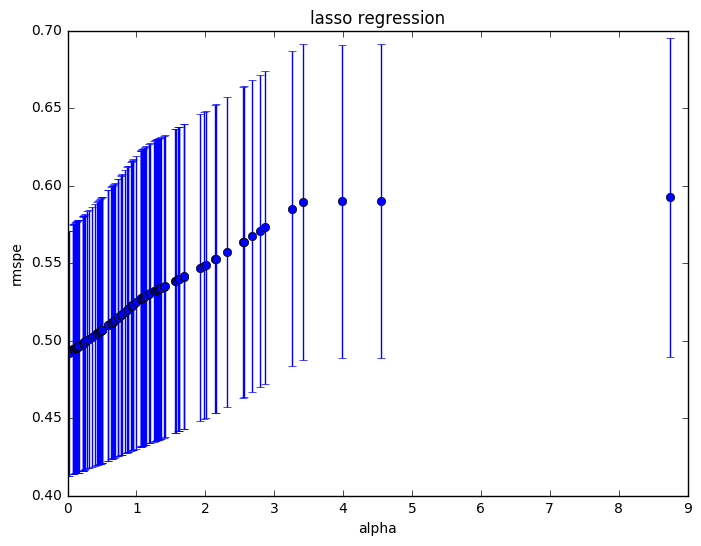

In [17]:
plt.figure(figsize=(8,6))
plt.errorbar(cv_results[cv_results['alpha']<10].alpha, 
             cv_results[cv_results['alpha']<10].rmspe_mean, 
             cv_results[cv_results['alpha']<10].rmspe_std, linestyle='None', marker='o')
plt.title('lasso regression')
plt.xlabel('alpha')
plt.ylabel('rmspe')
plt.show()

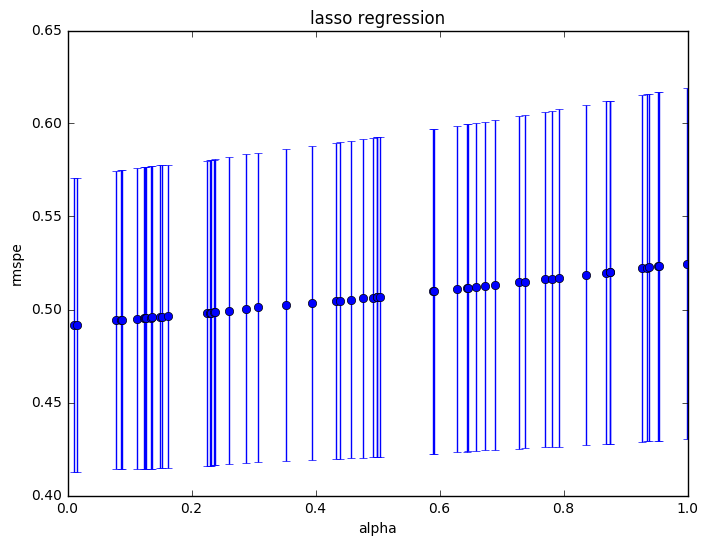

In [18]:
plt.figure(figsize=(8,6))
plt.errorbar(cv_results[cv_results['alpha']<1].alpha, 
             cv_results[cv_results['alpha']<1].rmspe_mean, 
             cv_results[cv_results['alpha']<1].rmspe_std, linestyle='None', marker='o')
plt.title('lasso regression')
plt.xlabel('alpha')
plt.ylabel('rmspe')
plt.show()